In [1]:
import os 
import json
from tqdm import tqdm
import pickle

import numpy as np
import torch
import pyro
from pyro.infer import SVI,Trace_ELBO,TraceMeanField_ELBO
from torch.distributions.transforms import SoftplusTransform
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta

import matplotlib.pyplot as plt
import seaborn as sns

from Auxiliary import Hawkes, GP, Estimator

checkpoint = '/'.join(os.getcwd().split("\\"))+'/Data/' + 'Processed Data/'

with open(checkpoint + 'dat.json') as f:
    dat = json.load(f)

events = []
ads = []
spacings = []
for key in list(dat.keys()): 
    events.append(torch.tensor(dat[key]["events"]).type(torch.double))
    ads.append(torch.tensor(dat[key]["ads"]).type(torch.double))
    spacings.append(torch.tensor([1000]+dat[key]["ad_spacing"]).type(torch.double))

T= 78

# split obs with and without events
counts = []
for i in range(len(events)):
    counts.append(len(events[i]))
counts = np.array(counts)
events_id_actual = np.where(counts>0)[0]
events_id_censored = np.where(counts==0)[0]
ratio = len(events_id_censored)/len(counts)

# prepare strata

q = np.array(list(range(1,11,1)))/10
cut_points = np.quantile(counts[events_id_actual],q)
quantiles_subsets = [np.where(counts<=cut_points[0])[0]]
for k in range(1,len(q)):
    quantiles_subsets.append(np.where((cut_points[k-1]<=counts)&(counts<=cut_points[k]))[0])

# Sanity Check

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:04<00:00,  3.31it/s]


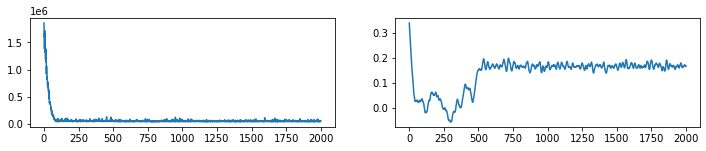

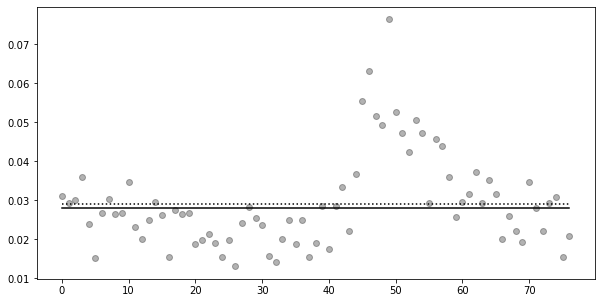

In [12]:
'''''''''         '''''''''
''' Estimation Settings '''
'''''''''         '''''''''
n_steps = 2000
minibatch = 100
n_particles = 3
''''''''''''''''''''''''
''''''''''''''''''''''''

pyro.clear_param_store()
current = Estimator.Poisson_test_bench(torch.tensor(counts),minibatch) 
elbo = TraceMeanField_ELBO(num_particles=n_particles)
optim = pyro.optim.ClippedAdam({"lr": 1e-2})
svi = SVI(current.model, current.guide, optim, loss=elbo)

losses = []
gpmean      = torch.tensor([np.sqrt(np.mean(counts)/T)*2])
batch_means = torch.tensor([np.sqrt(np.mean(counts)/T)*2])
for step in tqdm(range(n_steps)):
    subsample = np.random.choice(events_id_censored, size=int((ratio)*minibatch), replace=False)
    for k in range(1,len(q)):
            subsample = np.append(subsample,np.random.choice(quantiles_subsets[k], size=int(ratio*(q[k]-q[k-1])*minibatch), replace=False))
    subsample = torch.tensor(np.unique(subsample)).long()
    new =svi.step(subsample)
    losses.append(new)
    new_params = {k: v for k, v in pyro.get_param_store().items() }
    gpmean      = torch.cat((gpmean,new_params["Hyper_Mean"].reshape(1).clone().detach().requires_grad_(False)),dim=0)
    batch_means = torch.cat((batch_means,torch.tensor(counts)[subsample].type(torch.double).mean().reshape(1)/(T*minibatch)),dim=0)
losses = np.array(losses)

fig, ax = plt.subplots(1,2,figsize=(12, 2))
ax[0].plot(losses)
ax[1].plot(gpmean)
plt.show()

timesteps = torch.arange(0,T-1).type(torch.double)
timeseries = np.zeros(T-1)
for i in range(len(events)):
    for t in events[i]:
        timeseries[torch.floor(t).numpy().astype(int)]+=1
timeseries=timeseries/len(events)

model_intensity = gpmean[-1].pow(2).expand(len(timesteps)) 
fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.plot(timesteps, (counts.mean()/T)*np.ones(len(timesteps)), color = "black", linestyle = ":",label="Inferred")
plt.show()

# Estimation

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [7:38:17<00:00,  2.75s/it]


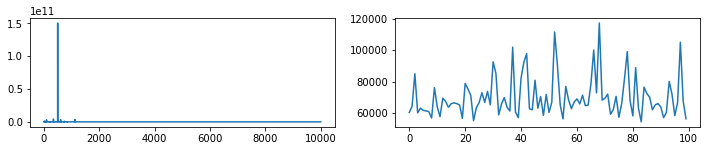

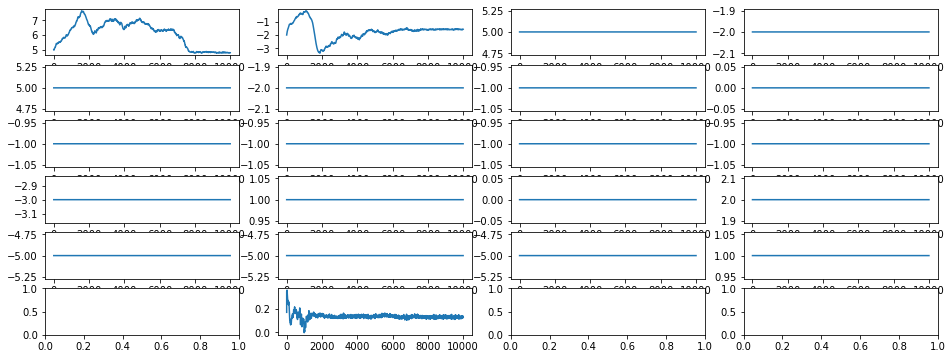

In [12]:
'''''''''         '''''''''
''' Estimation Settings '''
'''''''''         '''''''''
n_steps = 10000
count_of_inducing_points = 5
minibatch = 100
n_particles = 5
starting_vals = torch.tensor([5.,-2., 
                              5.,-2.,
                              5.,-2.]
                             + [-1,  0, -1, 
                                -1, -1, -1]
                             + [-3.,  1., 0.,  2,
                                -5., -5., -5.,  1.]).type(torch.double)

def separate_lr(param_name):
    if param_name == 'Hyper': return {"lr": 1e-2}
    elif param_name == 'Hyper_Mean': return {"lr": 1e-2}
    elif param_name == 'm': return {"lr": 1e-2}
    elif param_name == 'S': return {"lr": 1e-2}
    elif param_name == 'Z': return {"lr": 1e-2}
    else: return {"lr": 1e-3}

''''''''''''''''''''''''
''''''''''''''''''''''''

pyro.clear_param_store()
current = Estimator.GP_point_process(events,ads,spacings,starting_vals,minibatch,count_of_inducing_points) 
elbo = TraceMeanField_ELBO(num_particles=n_particles)
optim = pyro.optim.ClippedAdam(separate_lr)
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
params = torch.clone(starting_vals).detach().requires_grad_(False).reshape(1,-1)
gpmean = torch.tensor([np.sqrt(np.mean(counts)/T)])
inducing_points = torch.zeros(count_of_inducing_points).reshape(1,-1)
for step in tqdm(range(n_steps)):
    subsample = np.random.choice(events_id_censored, size=int((ratio)*minibatch), replace=False)
    for k in range(1,len(q)):
            subsample = np.append(subsample,np.random.choice(quantiles_subsets[k], size=int(ratio*(q[k]-q[k-1])*minibatch), replace=False))
    subsample = torch.tensor(np.unique(subsample)).long()
    new =svi.step(subsample)
    losses.append(new)
    new_params = {k: v for k, v in pyro.get_param_store().items() }
    params = torch.cat((params,new_params["Hyper"].reshape(1,-1).clone().detach().requires_grad_(False)),dim=0)
    gpmean = torch.cat((gpmean,new_params["Hyper_Mean"].reshape(1).clone().detach().requires_grad_(False)),dim=0)
    inducing_points = torch.cat((inducing_points,new_params["m"].reshape(1,-1).clone().detach().requires_grad_(False)),dim=0)
losses = np.array(losses)
fig, ax = plt.subplots(1,2,figsize=(12, 2))
ax[0].plot(losses)
ax[1].plot(losses[-100:])
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}
pickle.dump(posterior, open(checkpoint+"SVI_prior_estimates.p", "wb"))
fig, ax = plt.subplots(6,4,figsize=(16, 6))
i,j=0,0
for k in range(starting_vals.shape[0]):
    ax[i,j].plot(params[:,k].numpy())
    j+=1
    if j>3:
        j=0
        i+=1
ax[5,1].plot(gpmean.numpy())
plt.show()

# Estimation results

Plot posterior predictive of baseline, ad response function, and feedback function

Check how other Bayesians report their results

# Intensity tracking plot

Need to explain what the empirical intensity is

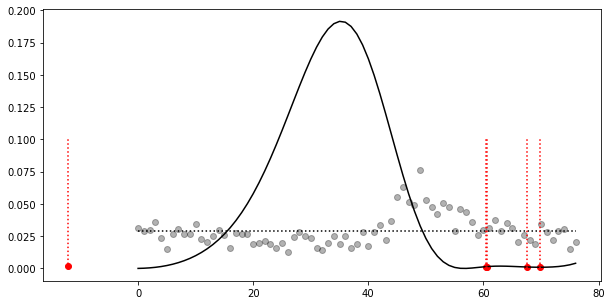

In [14]:
# load checkpoint
posterior = pickle.load(open(checkpoint+"SVI_prior_estimates.p", "rb"))

timesteps = torch.arange(0,T-1).type(torch.double)

# find mean empirical intensity
timeseries = np.zeros(T-1)
for i in range(len(events)):
    for t in events[i]:
        timeseries[torch.floor(t).numpy().astype(int)]+=1
timeseries=timeseries/len(events)

# posterior gp
post_hypmean = posterior['Hyper_Mean'].type(torch.double)
post_Z = posterior['Z'].type(torch.double)
post_m_z = posterior['m'].type(torch.double)
post_S_z = posterior['S'].matmul(posterior['S'].T).type(torch.double)
post_kernel = torch.exp(posterior['Hyper'][:6]).type(torch.double)
kernel_SE = GP.SqExp_kernel(post_kernel[0],post_kernel[1])
kernel_P1 = GP.Periodic_kernel(post_kernel[2],post_kernel[3],torch.tensor([1]).type(torch.double))
kernel_P7 = GP.Periodic_kernel(post_kernel[4],post_kernel[5],torch.tensor([7]).type(torch.double))
kernel = GP.additive_composite_kernel([kernel_SE#, kernel_P1,kernel_P7
                                      ])

gp = GP.GP(post_hypmean,GP.SqExp_kernel(16,10))
#baseline = Hawkes.GP_intensity(gp,post_Z,post_m_z).density(timesteps)
baseline = gp.posterior_cond(post_Z,timesteps,post_m_z)[0].pow(2)
model_intensity = baseline

fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.plot(timesteps,(counts.mean()/T)*np.ones(len(timesteps)), color = "black", linestyle = ":",label="Inferred")
ax.vlines(post_Z,ymin=0.,ymax=.1,colors="red",linestyle=":")
ax.scatter(post_Z,post_m_z.pow(2),c="red")
plt.show()

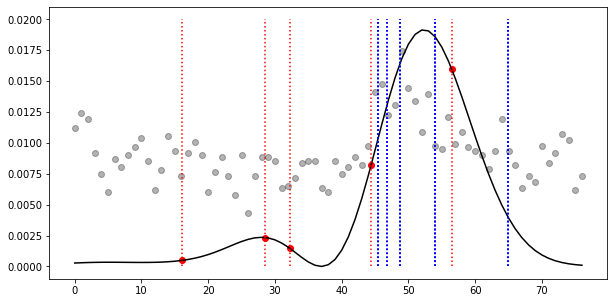

tensor(-89.7170)
tensor(-0.3437)


In [2]:
# load checkpoint
posterior = pickle.load(open(checkpoint+"SVI_prior_estimates.p", "rb"))

timesteps = torch.arange(0,T-1).type(torch.double)

# find mean empirical intensity
timeseries = np.zeros(T-1)
for i in range(len(events)):
    timeseries[torch.floor(events[i]).numpy().astype(int)]+=1
timeseries=timeseries/len(events)

# posterior gp
post_hypmean = posterior['Hyper_Mean'].type(torch.double)
post_Z = posterior['Z'].type(torch.double)
post_m_z = posterior['m'].type(torch.double)
post_S_z = posterior['S'].matmul(posterior['S'].T).type(torch.double)
post_kernel = torch.exp(posterior['Hyper'][:6]).type(torch.double)
kernel_SE = GP.SqExp_kernel(post_kernel[0],torch.ones(1))
kernel_P1 = GP.Periodic_kernel(post_kernel[2],post_kernel[3],torch.tensor([1]).type(torch.double))
kernel_P7 = GP.Periodic_kernel(post_kernel[4],post_kernel[5],torch.tensor([7]).type(torch.double))
kernel = GP.additive_composite_kernel([kernel_SE#, kernel_P1,kernel_P7
                                      ])

gp = GP.GP(post_hypmean,kernel)

baseline = Hawkes.GP_intensity(gp,post_Z,post_m_z).density(timesteps)

model_intensity = baseline

fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.vlines(post_Z,ymin=0.,ymax=.02,colors="red",linestyle=":")
ax.scatter(post_Z,post_m_z.pow(2),c="red")
ax.vlines(events[1],ymin=0.,ymax=.02,colors="blue",linestyle=":")
plt.show()

print(torch.sum(torch.log(Hawkes.GP_intensity(gp,post_Z,post_m_z).density(events[1]))))
print(-Hawkes.GP_intensity(gp,post_Z,post_m_z).integral(0,78))

# Transform time analysis

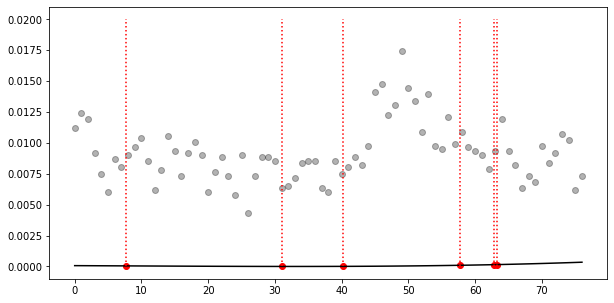

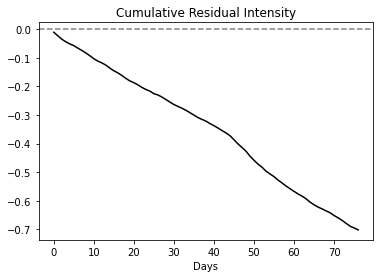

In [8]:
# load checkpoint
posterior = pickle.load(open(checkpoint+"SVI_prior_estimates.p", "rb"))

timesteps = torch.arange(0,T-1).type(torch.double)

# find mean empirical intensity
timeseries = np.zeros(T-1)
for i in range(len(events)):
    timeseries[torch.floor(events[i]).numpy().astype(int)]+=1
timeseries=timeseries/len(events)

# posterior gp
post_hypmean = posterior['Hyper_Mean'].type(torch.double)
post_Z = posterior['Z'].type(torch.double)
post_m_z = posterior['m'].type(torch.double)
post_S_z = posterior['S'].matmul(posterior['S'].T).type(torch.double)
post_kernel = torch.exp(posterior['Hyper'][:6]).type(torch.double)
kernel_SE = GP.SqExp_kernel(post_kernel[0],torch.ones(1))
#kernel_P1 = GP.Periodic_kernel(post_kernel[2],post_kernel[3],torch.tensor([1]).type(torch.double))
#kernel_P7 = GP.Periodic_kernel(post_kernel[4],post_kernel[5],torch.tensor([7]).type(torch.double))
kernel = GP.additive_composite_kernel([kernel_SE #, kernel_P1,kernel_P7
                                      ])
gp = GP.GP(post_hypmean,kernel)
baseline = (gp.posterior_cond(post_Z,timesteps,post_m_z)[0]).pow(2)

# feedback posterior
feedback_params = torch.exp(posterior['Hyper'][6:12]).type(torch.double)
feedback  = Hawkes.Delay_Exp_Kernel(feedback_params[0:3])
feedback_intensity = torch.zeros(T-1)
for i in range(len(events)):
    feedback_intensity += feedback.density(torch.arange(T-1),events[i])
feedback_intensity = feedback_intensity/len(events)

# ad response posterior

model_intensity = baseline #+ feedback_intensity

fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.vlines(post_Z,ymin=0.,ymax=.02,colors="red",linestyle=":")
ax.scatter(post_Z,(post_m_z).pow(2),c="red")
plt.show()

residual = model_intensity.numpy()-timeseries
plt.plot(np.cumsum(residual),color='black')
plt.axhline(0,linestyle='--',color='grey')
plt.title("Cumulative Residual Intensity")
plt.xlabel("Days")
plt.show()

In [ ]:


gpi = GP_intensity(gp,post_Z,post_m_z)

all_transform_times = np.zeros(1)
for i in tqdm(range(100)):
    transform_times = np.zeros(len(data[i]))
    for t in range(len(transform_times)):
        transform_times[t] += gpi.integral(0,data[i][t]) + feedback.cumulative(data[i][t],data[i])
    transform_times[1:]-=transform_times[:-1]
    all_transform_times = np.hstack((all_transform_times,transform_times[1:]))
    
# get the transform time CDFs 
C = 1-np.exp(-all_transform_times[1:])
plt.hist(C,color="black",density=True)
plt.title("Does it look uniform?")
plt.show()

# plot C_{k} vs C_{k+1} to see if there's unaccounted for endogeneity 
fig, ax = plt.subplots(nrows=1,figsize=(5,5))
ax.scatter(C[:-1],C[1:],color="black",alpha=0.05)
ax.set_ylabel("C_{k+1}")
ax.set_xlabel("C_{k}")
ax.set_title("Does it look homogeneous?")
plt.show()